# XGBRegression (LMA features to P,A,D coordinates)

## Imports

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.lines as mlines

import tensorflow as tf

import sklearn
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold

import xgboost as xgb

xgb.set_config(verbosity=0)

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import normalize

from sklearn.utils import shuffle
from mpl_toolkits import mplot3d

## Load Data

In [2]:
dataset = pd.read_csv('datasets/Fs_O_S_KIN_FULL.csv')
print(dataset.shape)

(15949, 32)


### Split into Test and Train data

In [3]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

train_dataset = shuffle(train_dataset)
test_dataset = shuffle(test_dataset)

No Training Samples: 12759
No Test Samples: 3190


### Split Features from Targets

In [4]:
train_X = train_dataset.copy()
test_X = test_dataset.copy()

train_y = pd.concat([train_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)
test_y = pd.concat([test_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A', 'EMOTION_D']], axis=1)

test_y_p = test_y.iloc[:,0]
train_y_p = train_y.iloc[:,0]

test_y_a = test_y.iloc[:,1]
train_y_a = train_y.iloc[:,1]

test_y_d = test_y.iloc[:,2]
train_y_d = train_y.iloc[:,2]

In [5]:
train_X.head()

,max_hand_distance,avg_l_hand_hip_distance,avg_r_hand_hip_distance,max_stride_length,avg_l_hand_chest_distance,avg_r_hand_chest_distance,avg_l_elbow_hip_distance,avg_r_elbow_hip_distance,avg_chest_pelvis_distance,avg_neck_chest_distance,...,l_foot_speed,r_foot_speed,neck_speed,l_hand_acceleration_magnitude,r_hand_acceleration_magnitude,l_foot_acceleration_magnitude,r_foot_acceleration_magnitude,neck_acceleration_magnitude,average upper_body_volume,average lower_body_volume
9936,-1.149301,0.233348,0.211389,-0.079304,-0.059946,-0.117005,-0.456167,-0.449316,-0.127851,0.070074,...,-0.320147,-0.194905,-0.408895,0.542524,0.425948,-0.438664,-0.605953,0.038478,0.083000,0.799910
3893,2.581260,-0.408311,3.234576,0.753494,0.703081,1.764749,0.645747,3.020891,1.434214,-1.214415,...,-0.457826,-0.475159,-0.328679,0.226667,1.192581,0.395796,0.088395,-0.805052,2.306530,2.345400
12827,-2.173386,1.050334,0.477732,0.034348,-2.078248,-2.468015,-1.299380,-2.373126,-0.678797,0.466083,...,-0.399411,-0.377877,-0.376962,-0.796957,-0.657035,-0.801047,-0.820340,-0.509143,-0.931912,-1.152337
11951,1.916982,2.425990,2.283577,-1.199460,0.165583,0.417854,1.100160,1.621533,-0.184807,-0.024756,...,-0.441711,-0.630356,-0.461776,-0.700927,1.217194,0.346297,0.018627,0.291657,1.014537,-0.857120
425,-1.115295,-0.824572,-1.022763,-0.191912,0.058768,-0.327020,-0.080924,-0.667017,-0.615821,-0.308718,...,-0.905519,-0.953059,-0.790633,-1.032980,-1.113897,-0.624840,-0.589100,-0.827470,-0.953706,-0.114581


In [6]:
train_y.head()

,EMOTION_P,EMOTION_A,EMOTION_D
9936,0.60,0.50,0.2
3893,-0.50,0.60,0.9
12827,-0.40,0.25,-0.1
11951,0.60,0.50,0.2
425,-0.35,0.70,-0.8


In [7]:
train_X.describe().transpose()[['mean', 'std']]

,mean,std
max_hand_distance,0.005090,1.001583
avg_l_hand_hip_distance,0.000180,1.001166
avg_r_hand_hip_distance,0.000325,0.998942
max_stride_length,0.001231,1.001363
avg_l_hand_chest_distance,0.002311,0.998030
avg_r_hand_chest_distance,-0.000104,1.000631
avg_l_elbow_hip_distance,0.001891,0.998028
avg_r_elbow_hip_distance,-0.000346,0.999937
avg_chest_pelvis_distance,0.000229,0.987058
avg_neck_chest_distance,-0.004117,1.011678


## Define Model

In [8]:
xgbr = xgb.XGBRegressor(verbosity=1) 

params = {
        'eta': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 11, 21],
        'max_depth': [3, 6, 10, 15],
        'gamma': [0, 0.001, 0.01],
        'subsample': [0.75, 1],
        'colsample_bytree': [0.75, 1],
        'lambda': [1, 1.25],
        'alpha': [0.0, 0.25]
        }



model_p = xgb.XGBRegressor(
                    n_estimators=1500, learning_rate=0.05, max_depth=10, min_child_weight=5, 
                    reg_alpha=0.1, reg_lambda=1.0, gamma=0.0,
                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )


model_a = xgb.XGBRegressor(
                    n_estimators=1500, learning_rate=0.05, max_depth=15, min_child_weight=21, 
                    reg_alpha=0.1, reg_lambda=1.25, gamma=0.0,
                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )
                

model_d = xgb.XGBRegressor(
                    n_estimators=1500, learning_rate=0.05, max_depth=10, min_child_weight=5, 
                    reg_alpha=0.1, reg_lambda=1.0, gamma=0.0,
                    subsample=0.75, colsample_bytree=0.75, objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

## Train Model

### Pleasure Regression

In [9]:
model_p.fit(train_X, train_y_p)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75,
             enable_categorical=False, gamma=0.0, gpu_id=0,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=0.1, reg_lambda=1.0,
             scale_pos_weight=1, subsample=0.75, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

### Arousal Regression

In [10]:
model_a.fit(train_X, train_y_a)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75,
             enable_categorical=False, gamma=0.0, gpu_id=0,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=15,
             min_child_weight=21, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=0.1, reg_lambda=1.25,
             scale_pos_weight=1, subsample=0.75, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

### Dominance Regression

In [11]:
model_d.fit(train_X, train_y_d)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75,
             enable_categorical=False, gamma=0.0, gpu_id=0,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=10,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=12, num_parallel_tree=1,
             predictor='auto', random_state=0, reg_alpha=0.1, reg_lambda=1.0,
             scale_pos_weight=1, subsample=0.75, tree_method='gpu_hist',
             validate_parameters=1, verbosity=None)

## Test Model

### Training Score

In [12]:
score = model_p.score(train_X, train_y_p)  

print("Pleasure")
print("Training score: ", score)

print()

score = model_a.score(train_X, train_y_a)  

print("Arousal")
print("Training score: ", score)

score = model_d.score(train_X, train_y_d)  

print()

print("Dominance")
print("Training score: ", score)

Pleasure
Training score:  0.9999278385169481

Arousal
Training score:  0.9998690439476002

Dominance
Training score:  0.9999541100040741


### Test Set MAE & MSE

In [13]:
pred_y_p = model_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
mae = mean_absolute_error(test_y_p, pred_y_p)
print("Pleasure")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_a = model_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
mae = mean_absolute_error(test_y_a, pred_y_a)
print("\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_d = model_d.predict(test_X)
mse = mean_squared_error(test_y_d, pred_y_d)
mae = mean_absolute_error(test_y_d, pred_y_d)
print("\nDominance")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

Pleasure
MSE: 0.13
MAE: 0.26

Arousal
MSE: 0.08
MAE: 0.22

Dominance
MSE: 0.21
MAE: 0.35


### 10-Fold Cross Validation Average Score

### Graphs

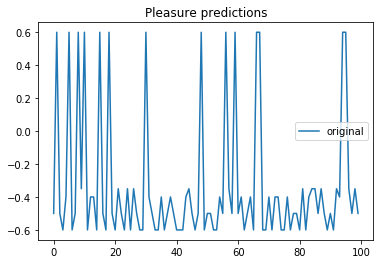

In [14]:
x_ax = range(100)
plt.plot(x_ax, test_y_p[0:100], label="original")

plt.title("Pleasure predictions")

plt.legend()
plt.show()

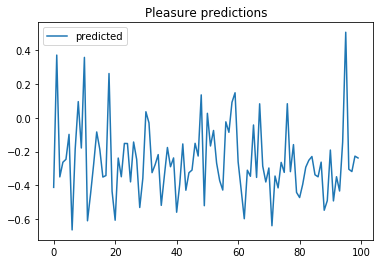

In [15]:
x_ax = range(100)
plt.plot(x_ax, pred_y_p[0:100], label="predicted")

plt.title("Pleasure predictions")

plt.legend()
plt.show()

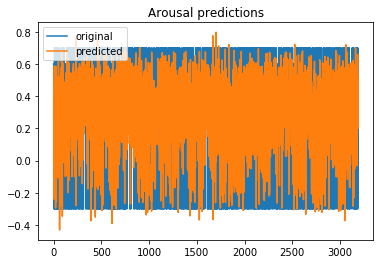

In [16]:
x_ax = range(len(test_y_a))
plt.plot(x_ax, test_y_a, label="original")
plt.plot(x_ax, pred_y_a, label="predicted")

plt.title("Arousal predictions")

plt.legend()
plt.show()

### Prediction Examples

In [17]:
row=test_X.iloc[1]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)
y_d = model_d.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[1]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

Real: [0.6 0.5 0.2]
Predicted: [0.36919835, 0.481793, 0.073732086]


In [18]:
row=test_X.iloc[421]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)
y_d = model_d.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[421]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

Real: [-0.35  0.7  -0.8 ]
Predicted: [-0.13406685, 0.3928816, -0.05206738]


In [19]:
row=test_X.iloc[999]

x = np.asarray([row])

y_p = model_p.predict(x)
y_a = model_a.predict(x)
y_d = model_d.predict(x)

print('Real: %s' % np.asarray(test_y.iloc[999]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

Real: [-0.5  0.6  0.9]
Predicted: [-0.45573688, 0.31314325, 0.07819758]


## Save Models

In [185]:
# save to JSON
model_p.save_model("models/l2p_dance_model_Fs2_O.json")
model_a.save_model("models/l2a_dance_model_Fs2_O.json")
model_d.save_model("models/l2d_dance_model_Fs2_O.json")

## Load Models

In [155]:
model_p = xgb.XGBRegressor(verbosity=0)
model_p.load_model("models/l2p_dance_model.json")

model_a = xgb.XGBRegressor(verbosity=0)
model_a.load_model("models/l2a_dance_model.json")

model_d = xgb.XGBRegressor(verbosity=0)
model_d.load_model("models/l2d_dance_model.json")

### Graphs

In [172]:
pred_y_p = model_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
mae = mean_absolute_error(test_y_p, pred_y_p)
print("Pleasure")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)


pred_y_a = model_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
mae = mean_absolute_error(test_y_a, pred_y_a)
print("\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_d = model_d.predict(test_X)
mse = mean_squared_error(test_y_d, pred_y_d)
mae = mean_absolute_error(test_y_d, pred_y_d)
print("\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

Pleasure
MSE: 0.03
MAE: 0.06

Arousal
MSE: 0.02
MAE: 0.05

Arousal
MSE: 0.04
MAE: 0.07


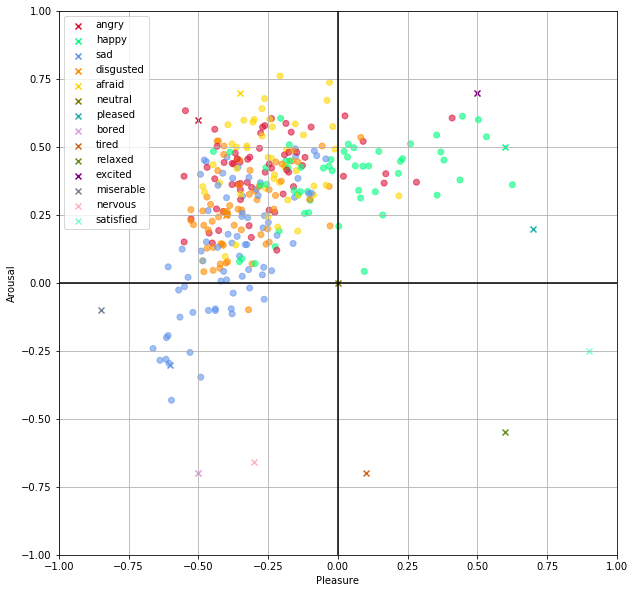

In [20]:
x = pred_y_p[0:300]
y = pred_y_a[0:300]

x_reference = [-0.5, 0.6, -0.6, 
               -0.4, 
               -0.35, 0.0, 0.7, -0.5, 0.1, 0.6, 0.5, -0.85, -0.3, 0.9]
y_reference = [0.6, 0.5, -0.3, 
               0.25, 
               0.7, 0.0, 0.2, -0.7, -0.7, -0.55, 0.7, -0.1, -0.66, -0.25]
colors_reference = ["crimson", "springgreen", "cornflowerblue", 
                    "darkorange", 
                    "gold", "olive", 
                    "lightseagreen", "plum", "chocolate", "olivedrab", "purple", "lightslategray",
                    "lightpink", "aquamarine"]

colors = []

color_map = {
    (-0.5, 0.6): "crimson",
    (0.6, 0.5): "springgreen",
    (-0.6, -0.3): "cornflowerblue",
    (-0.4, 0.25): "darkorange" ,
    (-0.35, 0.7): "gold",
    (0.0, 0.0): "olive", 
    (0.7, 0.2): "lightseagreen",
    (-0.5, -0.7): "plum",
    (0.1, -0.7): "chocolate",
    (0.6, -0.55): "olivedrab",
    (0.5, 0.7): "purple",
    (-0.85, -0.1): "lightslategray",
    (-0.3, -0.66): "lightpink",
    (0.9, -0.25): "aquamarine",
}

conv_dict = {
    (-0.5, 0.6): "angry",
    (0.6, 0.5): "happy",
    (-0.6, -0.3): "sad",
    (-0.4, 0.25): "disgusted" ,
    (-0.35, 0.7): "afraid",
    (0.0, 0.0): "neutral", 
    (0.7, 0.2): "pleased",
    (-0.5, -0.7): "bored",
    (0.1, -0.7): "tired",
    (0.6, -0.55): "relaxed",
    (0.5, 0.7): "excited",
    (-0.85, -0.1): "miserable",
    (-0.3, -0.66): "nervous",
    (0.9, -0.25): "satisfied",
    
}

for i in range(len(x)):
    point_coords = (test_y_p.iloc[i], test_y_a.iloc[i])
    
    colors.append(color_map[point_coords])

fig, ax = plt.subplots(figsize=(10,10))

for i in range(len(x_reference)):
    ax.scatter(x_reference[i], y_reference[i], c=colors_reference[i], label=conv_dict[(x_reference[i], y_reference[i])] , marker="x", linewidths=3)

ax.legend()

ax.scatter(x, y, c=colors, alpha=0.6)


line = mlines.Line2D([-1, 1], [0, 0], color='black')
line_2 = mlines.Line2D([0, 0], [-1, 1], color='black')
ax.add_line(line)
ax.add_line(line_2)


plt.ylim([-1,1])
plt.xlim([-1,1])


plt.xlabel('Pleasure')
plt.ylabel('Arousal')
plt.grid(True)

plt.show()



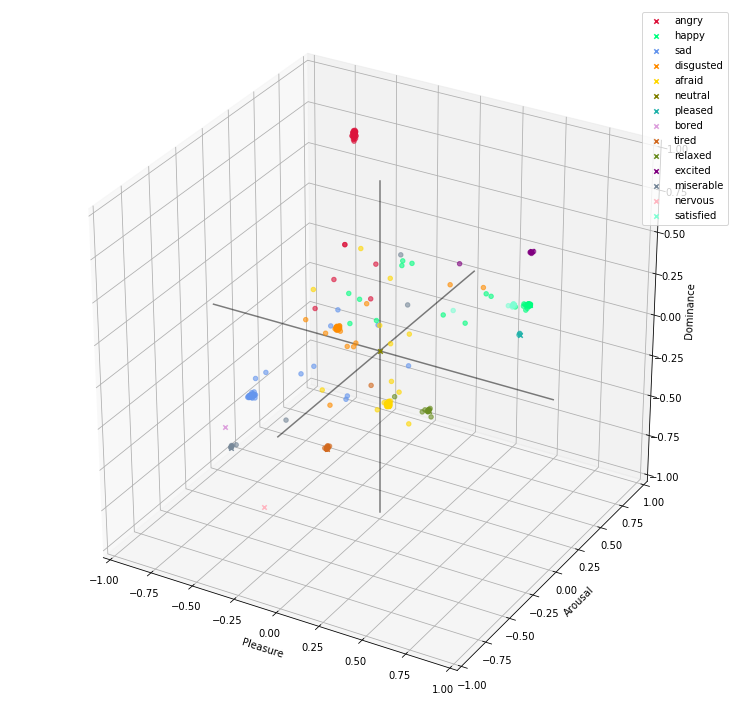

In [174]:
x = pred_y_p[0:300]
y = pred_y_a[0:300]
z = pred_y_d[0:300]

x_reference = [-0.5, 0.6, -0.6, 
               -0.4, 
               -0.35, 0.0, 0.7, -0.5, 0.1, 0.6, 0.5, -0.85, -0.3, 0.9]

y_reference = [0.6, 0.5, -0.3, 
               0.25, 
               0.7, 0.0, 0.2, -0.7, -0.7, -0.55, 0.7, -0.1, -0.66, -0.25]

z_reference = [ 0.9, 0.2, -0.3,
                -0.1,
                -0.8, 0.0, 0.2, -0.25, -0.2, 0.1, 0.4, -0.8, -0.7, 0.65]

colors_reference = ["crimson", "springgreen", "cornflowerblue", 
                    "darkorange", 
                    "gold", "olive", 
                    "lightseagreen", "plum", "chocolate", "olivedrab", "purple", "lightslategray",
                    "lightpink", "aquamarine"]

colors = []

color_map = {
    (-0.5, 0.6, 0.9): "crimson",
    (0.6, 0.5, 0.2): "springgreen",
    (-0.6, -0.3, -0.3): "cornflowerblue",
    (-0.4, 0.25, -0.1): "darkorange" ,
    (-0.35, 0.7, -0.8): "gold",
    (0.0, 0.0, 0.0): "olive", 
    (0.7, 0.2, 0.2): "lightseagreen",
    (-0.5, -0.7, -0.25): "plum",
    (0.1, -0.7, -0.2): "chocolate",
    (0.6, -0.55, 0.1): "olivedrab",
    (0.5, 0.7, 0.4): "purple",
    (-0.85, -0.1, -0.8): "lightslategray",
    (-0.3, -0.66, -0.7): "lightpink",
    (0.9, -0.25, 0.65): "aquamarine",
}

conv_dict = {
    (-0.5, 0.6, 0.9): "angry",
    (0.6, 0.5, 0.2): "happy",
    (-0.6, -0.3, -0.3): "sad",
    (-0.4, 0.25, -0.1): "disgusted" ,
    (-0.35, 0.7, -0.8): "afraid",
    (0.7, 0.2, 0.2): "pleased",
    (0.0, 0.0, 0.0): "neutral",
    (-0.5, -0.7, -0.25): "bored",
    (0.1, -0.7, -0.2): "tired",
    (0.6, -0.55, 0.1): "relaxed",
    (0.5, 0.7, 0.4): "excited",
    (-0.85, -0.1, -0.8): "miserable",
    (-0.3, -0.66, -0.7): "nervous",
    (0.9, -0.25, 0.65): "satisfied",   
}

for i in range(len(x)):
    point_coords = (test_y_p.iloc[i], test_y_a.iloc[i], test_y_d.iloc[i])
    
    colors.append(color_map[point_coords])

fig = plt.figure(figsize = (13, 13))
ax = plt.axes(projection ="3d")


for i in range(len(x_reference)):
    ax.scatter3D(x_reference[i], y_reference[i], z_reference[i], 
               c=colors_reference[i], 
               label=conv_dict[(x_reference[i], y_reference[i], z_reference[i])],
               marker="x", linewidths=3)

ax.legend()

ax.scatter(x, y, z, c=colors, alpha=0.6)


line = mplot3d.art3d.Line3D([-1, 1], [0, 0], [0,0], color='black', alpha=0.5)
line_2 = mplot3d.art3d.Line3D([0, 0], [-1, 1], [0,0], color='black', alpha = 0.5)
line_3 = mplot3d.art3d.Line3D([0, 0], [0, 0], [-1,1], color='black', alpha = 0.5)

ax.add_line(line)
ax.add_line(line_2)
ax.add_line(line_3)


ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

ax.set_xlabel('Pleasure')
ax.set_ylabel('Arousal')
ax.set_zlabel('Dominance')
plt.grid(True)

plt.show()



# Hyperparameter Grid Search with XGBoost

In [36]:
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

import sklearn
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error


import xgboost as xgb

xgb.set_config(verbosity=2)

from sklearn.metrics import mean_squared_error

## Load Data

In [22]:
dataset = pd.read_csv('datasets/Fs_O_S_KIN_FULL.csv')

### Split into Test and Train data

In [23]:
train_dataset = dataset.sample(frac=0.8, random_state=42)
test_dataset = dataset.drop(train_dataset.index)

print("No Training Samples:",train_dataset.shape[0])
print("No Test Samples:",test_dataset.shape[0])

train_dataset = shuffle(train_dataset)
test_dataset = shuffle(test_dataset)

No Training Samples: 12759
No Test Samples: 3190


### Split Features from Targets

In [24]:
train_X = train_dataset.copy()
test_X = test_dataset.copy()

train_y = pd.concat([train_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A', "EMOTION_D"]], axis=1)
test_y = pd.concat([test_X.pop(x) for x in ['EMOTION_P', 'EMOTION_A', "EMOTION_D"]], axis=1)

test_y_p = test_y.iloc[:,0]
train_y_p = train_y.iloc[:,0]

test_y_a = test_y.iloc[:,1]
train_y_a = train_y.iloc[:,1]

test_y_d = test_y.iloc[:,2]
train_y_d = train_y.iloc[:,2]

In [25]:
train_X.head()

,max_hand_distance,avg_l_hand_hip_distance,avg_r_hand_hip_distance,max_stride_length,avg_l_hand_chest_distance,avg_r_hand_chest_distance,avg_l_elbow_hip_distance,avg_r_elbow_hip_distance,avg_chest_pelvis_distance,avg_neck_chest_distance,...,l_foot_speed,r_foot_speed,neck_speed,l_hand_acceleration_magnitude,r_hand_acceleration_magnitude,l_foot_acceleration_magnitude,r_foot_acceleration_magnitude,neck_acceleration_magnitude,average upper_body_volume,average lower_body_volume
7445,1.114663,-0.887695,2.163802,1.179503,-0.319814,0.352967,0.272238,0.611437,-1.440289,0.358610,...,-0.660194,-0.554406,-0.085022,-1.153331,0.660109,-0.863834,-0.818913,-0.604026,0.043098,1.161091
14385,-0.459723,-0.714570,-0.887570,1.328990,0.565833,0.403955,0.319680,0.050488,0.318924,0.479999,...,1.009108,3.295503,2.433219,1.268149,0.873656,0.548101,2.436761,1.839166,-0.885098,-0.626656
4414,0.659229,0.084030,-0.424660,-1.499180,0.656154,0.727224,0.704592,0.439598,0.219734,0.560903,...,-0.171996,-0.415768,-0.438213,0.161646,-0.899342,-0.387776,-0.524189,-0.564792,0.314907,-1.344552
461,0.081677,-0.666926,0.602858,-0.540178,-0.739698,-1.574996,0.367129,-1.062141,-0.044651,-0.777566,...,-0.906952,-0.897176,-0.224219,-0.960332,-0.329011,-0.954841,-1.014810,-0.320567,0.244564,0.145996
6163,0.037908,-0.226237,-0.671017,0.282118,0.779046,-0.082937,0.641417,-0.485273,0.111937,0.228093,...,-0.615593,0.808544,-0.297885,0.044912,0.060806,0.211820,0.291286,0.951318,-0.525188,-0.551235


In [26]:
train_y.head()

,EMOTION_P,EMOTION_A,EMOTION_D
7445,-0.6,-0.30,-0.3
14385,-0.5,0.60,0.9
4414,-0.4,0.25,-0.1
461,-0.6,-0.30,-0.3
6163,0.6,0.50,0.2


In [27]:
train_X.describe().transpose()[['mean', 'std']]

,mean,std
max_hand_distance,0.005090,1.001583
avg_l_hand_hip_distance,0.000180,1.001166
avg_r_hand_hip_distance,0.000325,0.998942
max_stride_length,0.001231,1.001363
avg_l_hand_chest_distance,0.002311,0.998030
avg_r_hand_chest_distance,-0.000104,1.000631
avg_l_elbow_hip_distance,0.001891,0.998028
avg_r_elbow_hip_distance,-0.000346,0.999937
avg_chest_pelvis_distance,0.000229,0.987058
avg_neck_chest_distance,-0.004117,1.011678


## RandomSearchCV

In [38]:
# A parameter grid for XGBoost
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
params = {
        'eta': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 11, 21],
        'max_depth': [3, 6, 10, 15],
        'gamma': [0, 0.001, 0.01],
        'subsample': [0.75, 1],
        'colsample_bytree': [0.75, 1],
        'lambda': [1, 1.25],
        'alpha': [0.0, 0.25]
        }

n_iter = 150

In [39]:
model_p = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_a = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_d = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

In [ ]:
# Pleasure
# run randomized search
kfold = KFold(n_splits=5, shuffle=True)

random_search_p = RandomizedSearchCV(model_p, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_p.fit(train_X, train_y_p)


print("GridSearchCV took %.2f seconds"
      " parameter settings." % ((time.time() - start)))

In [ ]:
# Arousal
kfold = KFold(n_splits=5, shuffle=True)

random_search_a = RandomizedSearchCV(model_a, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_a.fit(train_X, train_y_a)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

In [ ]:
# Dominance
kfold = KFold(n_splits=5, shuffle=True)

random_search_d = RandomizedSearchCV(model_d, param_distributions=params,
                               cv=kfold, scoring='neg_mean_squared_error', n_iter = n_iter)

start = time.time()
random_search_d.fit(train_X, train_y_d)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

### Results

In [ ]:
best_regressor_p = random_search_p.best_estimator_

print(best_regressor_p.get_params())

In [ ]:
best_regressor_a = random_search_a.best_estimator_

print(best_regressor_a.get_params())

In [ ]:
best_regressor_d = random_search_d.best_estimator_

print(best_regressor_d.get_params())

In [ ]:
pred_y_p = best_regressor_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
mae = mean_absolute_error(test_y_p, pred_y_p)
print("Pleasure")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_a = best_regressor_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
mae = mean_absolute_error(test_y_a, pred_y_a)
print("\n\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_d = best_regressor_d.predict(test_X)
mse = mean_squared_error(test_y_d, pred_y_d)
mae = mean_absolute_error(test_y_d, pred_y_d)
print("\n\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

### Predictions

In [ ]:
sample_no = 6
row=test_X.iloc[sample_no]

x = np.asarray([row])

y_p = best_regressor_p.predict(x)
y_a = best_regressor_a.predict(x)
y_d = best_regressor_d.predict(x)


print('Real: %s' % np.asarray(test_y.iloc[sample_no]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

## GridSearchCV

In [128]:
# A parameter grid for XGBoost
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
params = {
        'eta': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 5, 11, 21],
        'max_depth': [3, 6, 10, 15],
        'gamma': [0, 0.001, 0.01],
        'subsample': [0.75, 1],
        'colsample_bytree': [0.75, 1],
        'lambda': [1, 1.25],
        'alpha': [0.0, 0.25]
        }
#params = {
#        'n_estimators': [1000, 2000],
#        'min_child_weight': [10, 25],
#        'gamma': [0, 0.005, 0.01],
#        'learning_rate': [0.01, 0.07, 0.1],
#        'max_depth': [10, 20],
#        'lambda': [1, 1.25],
#        'alpha': [0.0, 0.25]
#        }

In [129]:
model_p = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_a = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

model_d = xgb.XGBRegressor(
                    n_estimators=1500,
                    objective="reg:squarederror",
                    tree_method='gpu_hist'
                )

In [130]:
# Pleasure
# run randomized search
kfold = KFold(n_splits=5, shuffle=True)

random_search_p = GridSearchCV(model_p, param_grid=params,
                               cv=kfold, scoring='neg_mean_squared_error')

start = time.time()
random_search_p.fit(train_X, train_y_p)


print("GridSearchCV took %.2f seconds"
      " parameter settings." % ((time.time() - start)))

GridSearchCV took 34187.72 seconds parameter settings.


In [131]:
# Arousal
kfold = KFold(n_splits=5, shuffle=True)

random_search_a = GridSearchCV(model_a, param_grid=params,
                               cv=kfold, scoring='neg_mean_squared_error')

start = time.time()
random_search_a.fit(train_X, train_y_a)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

RandomizedSearchCV took 33562.72 seconds for 100 candidates parameter settings.


In [ ]:
# Dominance
kfold = KFold(n_splits=5, shuffle=True)

random_search_d = GridSearchCV(model_d, param_grid=params,
                               cv=kfold, scoring='neg_mean_squared_error')

start = time.time()
random_search_d.fit(train_X, train_y_d)


print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

### Results

In [83]:
best_regressor_p = random_search_p.best_estimator_

print(best_regressor_p.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.0500000007, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 21, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.25, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 0.75, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.25, 'eta': 0.05, 'alpha': 0.25}


In [84]:
best_regressor_a = random_search_a.best_estimator_

print(best_regressor_a.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.75, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.0500000007, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 21, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 0.75, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.25, 'eta': 0.05, 'alpha': 0.0}


In [85]:
best_regressor_d = random_search_d.best_estimator_

print(best_regressor_d.get_params())

{'objective': 'reg:squarederror', 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': 0, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.0500000007, 'max_delta_step': 0, 'max_depth': 15, 'min_child_weight': 21, 'missing': nan, 'monotone_constraints': '()', 'n_estimators': 1500, 'n_jobs': 12, 'num_parallel_tree': 1, 'predictor': 'auto', 'random_state': 0, 'reg_alpha': 0.25, 'reg_lambda': 1.25, 'scale_pos_weight': 1, 'subsample': 0.75, 'tree_method': 'gpu_hist', 'validate_parameters': 1, 'verbosity': None, 'lambda': 1.25, 'eta': 0.05, 'alpha': 0.25}


In [86]:
pred_y_p = best_regressor_p.predict(test_X)
mse = mean_squared_error(test_y_p, pred_y_p)
mae = mean_absolute_error(test_y_p, pred_y_p)
print("Pleasure")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_a = best_regressor_a.predict(test_X)
mse = mean_squared_error(test_y_a, pred_y_a)
mae = mean_absolute_error(test_y_a, pred_y_a)
print("\n\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

pred_y_d = best_regressor_d.predict(test_X)
mse = mean_squared_error(test_y_d, pred_y_d)
mae = mean_absolute_error(test_y_d, pred_y_d)
print("\n\nArousal")
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

Pleasure
MSE: 0.03
MAE: 0.06


Arousal
MSE: 0.02
MAE: 0.05


Arousal
MSE: 0.04
MAE: 0.07


### Predictions

In [144]:
sample_no = 6
row=test_X.iloc[sample_no]

x = np.asarray([row])

y_p = best_regressor_p.predict(x)
y_a = best_regressor_a.predict(x)
y_d = best_regressor_d.predict(x)


print('Real: %s' % np.asarray(test_y.iloc[sample_no]))
print('Predicted: %s' % [y_p[0], y_a[0], y_d[0]])

Real: [-0.5 -0.7]
Predicted: [-0.542336, -0.690465]
